# Star Sky Simulation

1. [Generate the field](#i-part-generate-the-field)
    1. [First Cell](#first-cell)
    2. [Second and Third Cell](#second-and-third-cells)
    3. [Fourth Cell](#fourth-cell)
    4. [Fifth Cell](#fifth-cell)

---

## I part: The field

### I.1 Packages and Parameters

After importing the packages will be used later on, I start with the definitions of the parameters of the system, like the dimension 
of the field `N`, the number of stars `M`, the power law for IMF and mass-luminosity relation, `alpha` and `beta` respectively.

The minimum `m_min` and the maximum `m_max` values for the masses of the sample are set here.

In [95]:

##* packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
import os

# getting th current directory
pwd = os.getcwd()

# dimension of the field matrix
N = int(1e2+1)
# number of stars
M = int(1e2)

# setting parameters of power laws
alpha = 2   # for IMF
beta  = 3   # for M-L relation
# minimum and maximum masses in solar mass units
m_min = 0.1; m_max = 20
# Initial Mass Function
IMF = lambda m : m**(-alpha)

# calculating IMF for the extreme masses
IMF_min = IMF(0.1); IMF_max = IMF(20) 

print(f'IMF for smallest and biggest stars:\nM\t\tIMF\n0.1 Msun\t{IMF_min}\n20  Msun\t{IMF_max}')


IMF for smallest and biggest stars:
M		IMF
0.1 Msun	99.99999999999999
20  Msun	0.0025


### I.2 Generating the sample

In order to populate the field from the IMF, the `generate_mass_array` is here implemented and the corresponding luminosity array is evaluated.

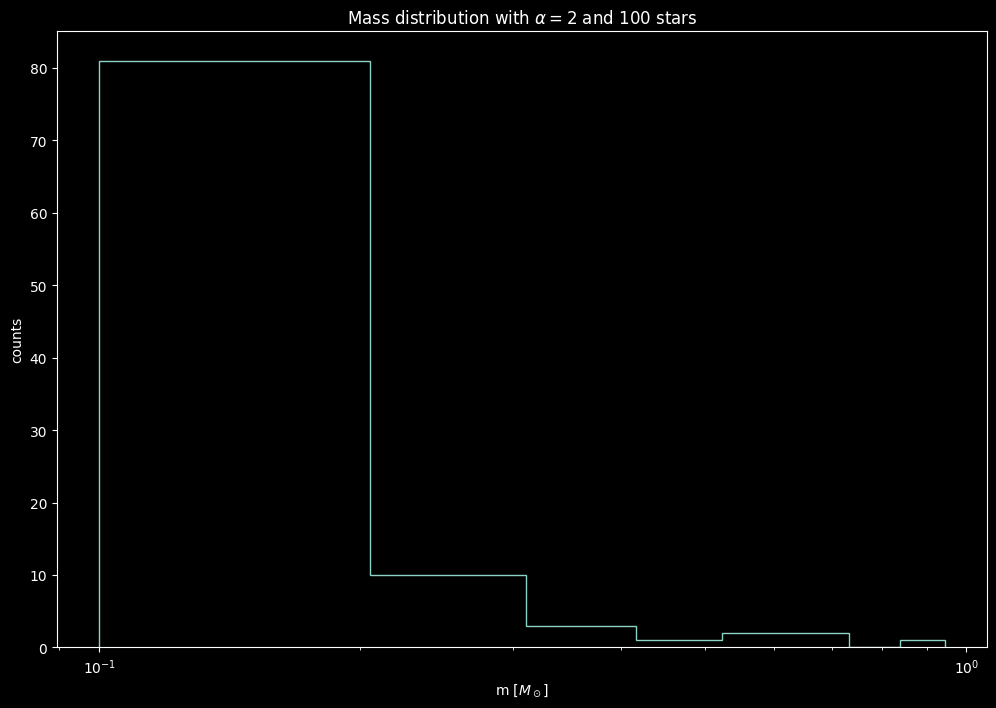

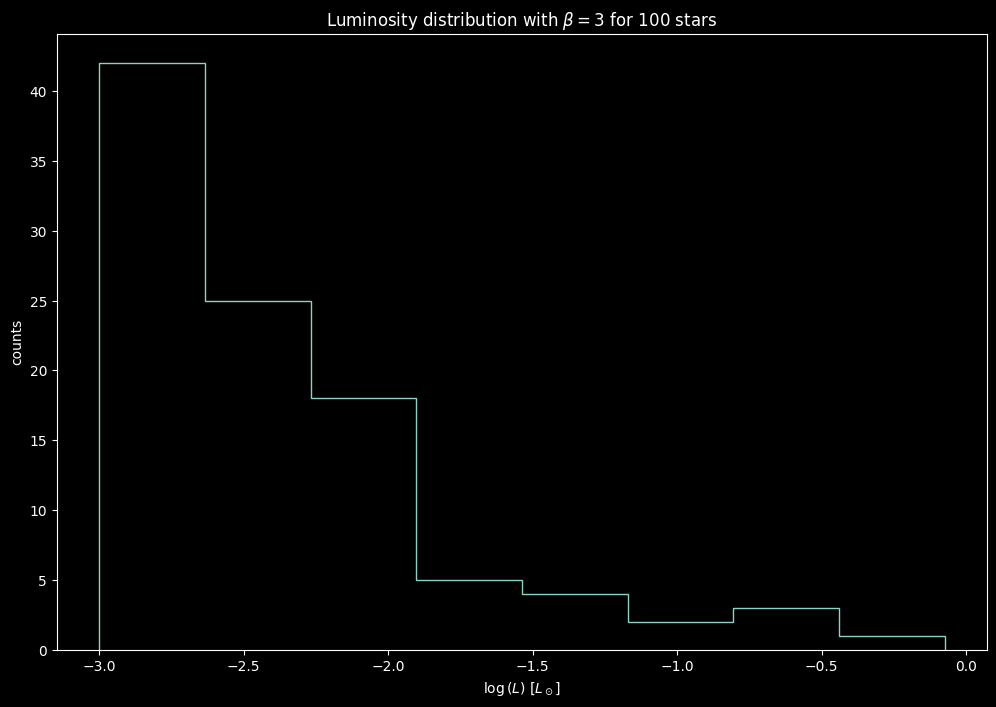

In [96]:

##* 
def generate_mass_array(m_min: float = 0.1, m_max: float = 20, alpha: float = 2,  sdim: int = M) -> np.ndarray:
    """Generating masses array from the IMF distribution
    The function takes the minimum and the maximum masses, the IMF 
    and generates a `sdim`-dimensional array of masses distributed like 
    IMF.

    The chosen method is a straightforward Monte Carlo: 
    generating uniformly random values for IMF and 
    calculating the corresponding mass.

    :param m_min: the minimum mass, defaults to 0.1 Msun
    :type m_min: float
    :param m_max: the maximum mass, defaults to 20 Msun
    :type imf_max: float
    :param alpha: the exponent of the power law, defaults to 2
    :type alpha: float
    :param sdim: number of stars, defaults to `M`
    :type sdim: int, optional

    :return: `sdim`-dimensional array of masses distributed like IMF
    :rtype: np.ndarray
    """
    # intial mass function
    IMF = lambda m : m**(-alpha)
    # evaluating IMF for the extremes
    imf_min = IMF(m_min)
    imf_max = IMF(m_max) 
    # initializing random seed
    np.random.seed()
    # generating the sample 
    return (np.random.rand(sdim)*(imf_min-imf_max)+imf_max)**(-1/alpha)

# M-dim array of masses in solar mass unit
m = generate_mass_array()

# M-dim array of luminosities in solar luminosity unit
L = m**beta


## Plot data for masses
plt.figure(1, figsize=(12,8))
plt.title(f'Mass distribution with $\\alpha = {alpha}$ and {M} stars')
plt.hist(m, bins='sturges',histtype='step')
plt.xscale('log')
plt.xlabel('m [$M_\odot$]')
plt.ylabel('counts')


## Plot data for corrisponfding luminosities
# plot the logarithm of L
plt.figure(2, figsize=(12,8))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
plt.hist(np.log10(L),bins='sturges',histtype='step')
plt.xlabel('$\log{(L)}$ [$L_\odot$]')
plt.ylabel('counts')


plt.show()



### I.3 Some useful stuff


I define a new class, named `star`, in order to store each parameter of generating stars in the following, and write a function `field_image()` just to display the field.

In [97]:

##* 
class star():
    """Star object class.
    This class will be used only to store the 
    parameters of star object.

    :param mass: star mass
    :type mass: float
    :param lum: star luminosity
    :type lum: float
    :param pos: star coordinates (x,y)
    :type pos: tuple[np.ndarray, np.ndarray]
    """
    def __init__(self, mass: float, lum: float, pos: tuple[np.ndarray, np.ndarray]):
        self.m   = mass        # star mass value
        self.lum = lum        # star luminosity value
        self.pos = pos        # star coordinates


##*   
def field_image(fig, image, F: np.ndarray, v: int = 0, sct: tuple = (0,-1)) -> None:
    """Function to display the field.
    It is possible to display only a section of the field 
    through the parameter `sct` 

    :param fig: figure variable
    :type fig: Any
    :param image: subplot variable
    :type image: Any
    :param F: field matrix
    :type F: np.ndarray
    :param v: set the color of the image, defaults to 0.
            *  1 for artificial color
            *  0 for grayscale
            * -1 for inverse grayscale
    :type v: int, optional
    :param sct: selected square section of the field, defaults to [0,-1]
    :type sct: tuple, optional
    """ 
    # extracting the edges of image
    a,b = sct
    # setting the color map from `v` param
    if v == 0: color = 'gray'
    elif v == 1: color = 'viridis' 
    else: color = 'gray_r' 
    # generating the image
    pic = image.imshow(F[a:b,a:b], cmap=color, norm='log')
    # generating the colorbar
    fig.colorbar(pic, ax=image, cmap=color, norm='log', location='bottom')
  

### I.4 Generating the source field

In this section the field without any kind of noise and seeing effect is generated. The aim is to get a `(N,N)` dimensional field with `M` stars, distributed like the `IMF` in mass and uniformly in positions. The whole luminosity of each star is in a single pixel, so one can treat every source like a _delta-function_ signal. 

After that functions to locate randomly stars and to update the field were implemented, I created another one to initialize the process.

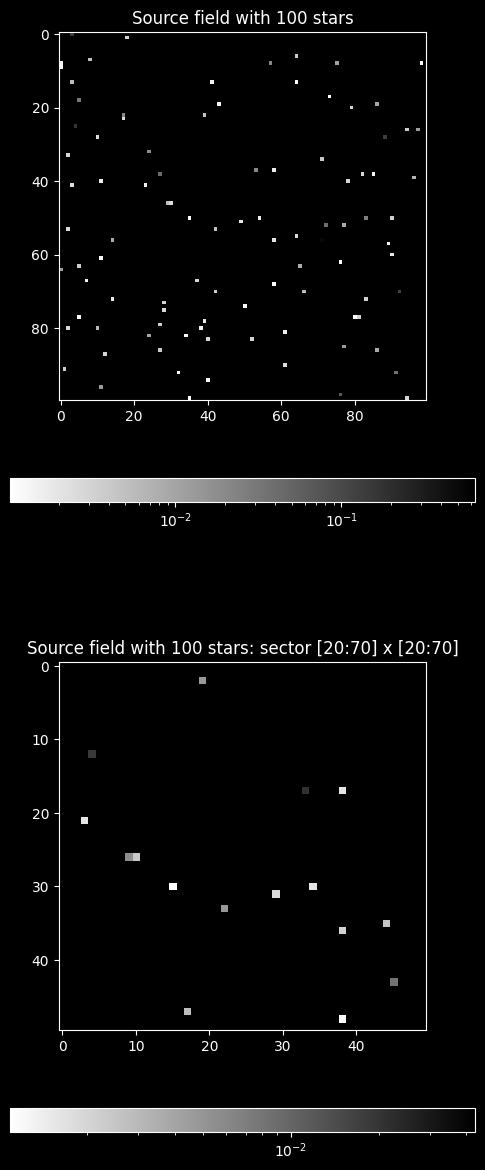

In [98]:

##* 
def star_location(sdim: int = M, dim: int = N) -> tuple[np.ndarray,np.ndarray]:
    """Function to locate the stars.
    It generates a list with all possible positions in the
    field matrix and draws `sdim` of those. Then it collects
    the drawn coordinates in two different arrays
    (x and y respectively).

    The parameter `replace` in `np.random.choice()` set to
    `False` forces each star has an unique position;
    in other words, no superimposition effect happens. 

    :param sdim: number of stars, defaults to `M`
    :type sdim: int, optional
    :param dim: size of the field, defaults to `N`
    :type dim: int, optional

    :return: tuple of star coordinates arrays `X` and `Y`
    :rtype: tuple

    .. todo:: 
        - #! Check the `replace` condition in `np.random.choice()`
          #? Is it a good choice?
    """
    # list with all possible positions in the field
    grid = [(i,j) for i in range(dim) for j in range(dim)]
    # drawing positions from grid for stars
    ind = np.random.choice(len(grid), size=sdim, replace=False)
    # making arrays of coordinates
    X = np.array([grid[i][0] for i in ind])
    Y = np.array([grid[i][1] for i in ind])
    return (X, Y)    

##* 
def update_field(F: np.ndarray, pos: tuple[np.ndarray, np.ndarray], lum: np.ndarray) -> np.ndarray:
    """Function to update the field.
    It adds the generated stars to the field.

    :param F: field matrix
    :type F: np.ndarray
    :param pos: star coordinates
    :type pos: tuple[np.ndarray, np.ndarray]
    :param lum: luminosities array
    :type lum: np.ndarray

    :return: updated field matrix
    :rtype: np.ndarray
    """
    # uppdating the field
    F[pos] += lum
    return F


def check_field(field: np.ndarray) -> np.ndarray:
    """Check the presence of negative values.
    The function finds possible negative values
    and substitutes them with 0.0

    :param field: field matrix
    :type field: ndarray

    :return: checked field matrix
    :rtype: ndarray
    """
    return np.where(field < 0, 0.0, field)


##*
def initialize(dim: int = N, sdim: int = M, masses: tuple[float, float] = (0.1, 20), alpha: float = 2, beta: float = 3) -> tuple:
    """Initialization function for the generation of the "perfect" sky
    It generates the stars and updates the field without any seeing 
    or noise effect.

    :param dim: size of the field, defaults to N
    :type dim: int, optional
    :param sdim: number of stars, defaults to M
    :type sdim: int, optional
    :param masses: the extremes of masses range, defaults to (0.1, 20)
    :type masses: tuple[float, float], optional
    :param alpha: exponent of IMF, defaults to 2
    :type alpha: float, optional
    :param beta: exponent of M-L relation, defaults to 3
    :type beta: float, optional

    :return: the field matrix F and :class: `star` object with all the stars informations
    :rtype: tuple
    """
    # generating an empty field (dim,dim) matrix
    F = np.zeros((dim,dim))
    m_inf, m_sup = masses
    # generating masses
    m = generate_mass_array(m_inf, m_sup, alpha=alpha, sdim=sdim)
    # evaluating corrisponding luminosities
    L = m**beta
    # locating the stars
    star_pos = star_location(sdim=sdim, dim=dim)
    # updating the field matrix
    F = check_field(update_field(F,star_pos,L))
    # saving stars infos
    S = star(m,L,star_pos)
    return F, S

# generation of the field and the stars
F, S = initialize()

## Plot
# variables to take a sector [inf:sup] x [inf:sup] of the field
inf = int(0.2*N)
sup = int(0.7*N)

fig, axs = plt.subplots(2, 1, figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = -1

img_field, img_zoom = axs

field_image(fig, img_field,F,v)
#img_field.imshow(1-F)
img_field.set_title(f'Source field with {M} stars')
field_image(fig, img_zoom,F,v,[inf,sup])
#img_zoom.imshow(1-F[inf:sup,inf:sup,:])
img_zoom.set_title(f'Source field with {M} stars: sector [{inf}:{sup}] x [{inf}:{sup}]')

plt.show()

### I.5 Atmospheric Seeing

The atmospheric seeing effect is considered in this exercise as the convolution of the previous _"perfect"_ field (_delta sources_) with a gaussian function. The variance of the latter is arbitrary; I chose a `sigma` of 0.5.

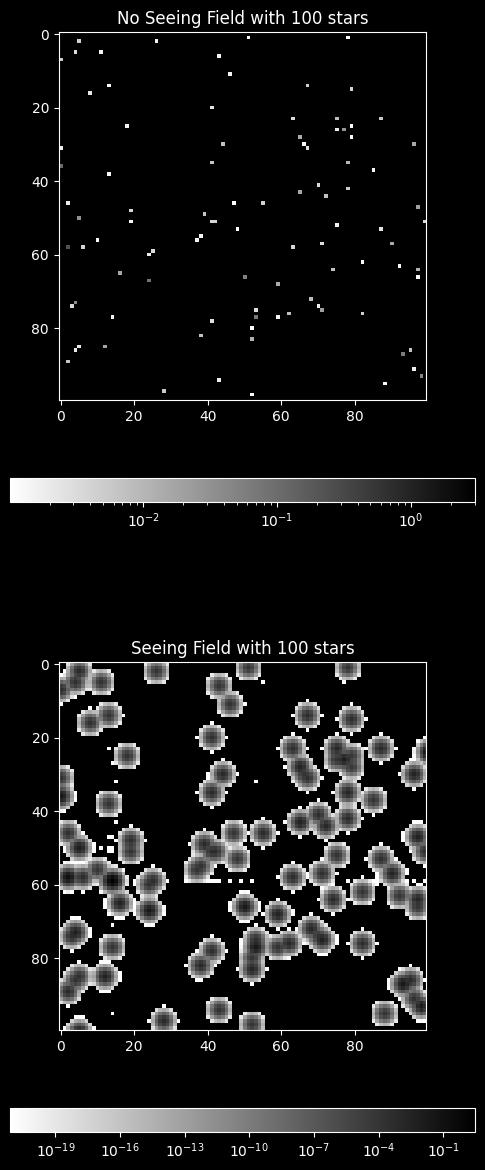

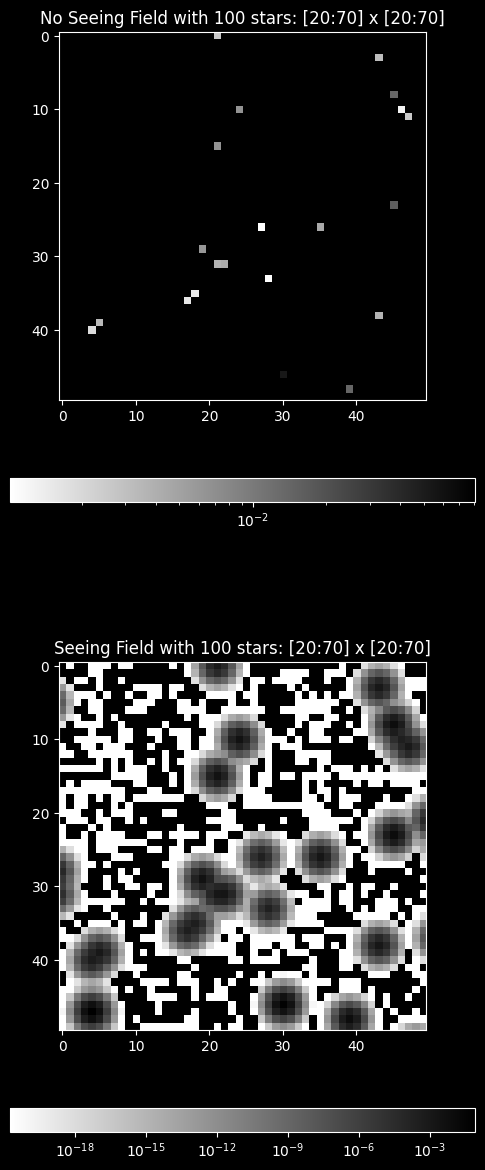

In [99]:
# SIXTH CELL
##* 
def gaussian(sigma: float = 0.5, dim: int = N) -> np.ndarray:
    """Gaussian matrix generator
    It generates a gaussian (`dim`,`dim`) matrix, centered in 
    (`dim//2`,`dim//2`)

    :param sigma: the root of the variance, defaults to 0.5
    :type sigma: float, optional
    :param dim: size of the field, defaults to N
    :type dim: int, optional
    
    :return: gaussian (dim,dim) matrix
    :rtype: np.ndarray
    """
    # generating arrays of all positions
    x = np.arange(dim, dtype=int)
    y = np.arange(dim, dtype=int)
    # shifting to center of the field
    x -= dim // 2  
    y -= dim // 2
    # gaussian function expression
    G = lambda r : np.exp(-(r/sigma)**2/2)
    # computing the outer product
    return np.outer(G(x),G(y))


##* 
def atm_seeing(field: np.ndarray, sigma: float = 0.5) -> np.ndarray:
    """Atmosferic seeing function
    It convolves the field with tha Gaussian to
    make the atmosferic seeing

    :param field: field matrix
    :type field: np.ndarray
    :param sigma: the root of variance of Gaussian, defaults to 0.5
    :type sigma: float, optional
    
    :return: field matrix with seeing
    :rtype: np.ndarray
    """
    # dim of the field
    n = len(field)
    # coping the field in order to preserve it
    see_field = np.copy(field)
    # convolution with gaussian seeing
    see_field = fftconvolve(see_field, gaussian(sigma=sigma, dim=n), mode='same')
    # checking the field and returning it
    return check_field(see_field)

# generation of the field and the stars
F, S = initialize()

## Plot variables
fig1, (img_field, img_field_seeing) = plt.subplots(2,1,figsize=(6,15))
fig2, (img_zoom, img_zoom_seeing)   = plt.subplots(2,1,figsize=(6,15))

#  0 : positive image
# -1 : negative image
v = -1

field_image(fig1, img_field,F,v)
img_field.set_title(f'No Seeing Field with {M} stars')
field_image(fig1, img_zoom,F,v,[inf,sup])
img_zoom.set_title(f'No Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')


# generation of the seeing image
F_s = atm_seeing(F)


field_image(fig2, img_field_seeing,F_s,v)
#img_field_seeing.imshow(1-F_s)
img_field_seeing.set_title(f'Seeing Field with {M} stars')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
#img_zoom_seeing.imshow(1-F_s[inf:sup,inf:sup,:])
img_zoom_seeing.set_title(f'Seeing Field with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

# path for images directory
picdir = os.path.join(pwd,'Pictures')

# par to save figures
#   1   save
#   0   not
sv = 0

if sv == 1:
    fig1.savefig(os.path.join(picdir,'field.png'))
    fig2.savefig(os.path.join(picdir,'zoom.png'))

plt.show()
    
    

### I.6 Background and Detector Noise

Due to the fact that both kinds of noise are uniform ones, only one function for the noise computation was implemented. 

The difference is just the value of the maximum: 
  - background: $0.2 \%$ of the luminosity of a solar mass star
  - detector: $3 \cdot 10^{-4}$ in solar luminosity units

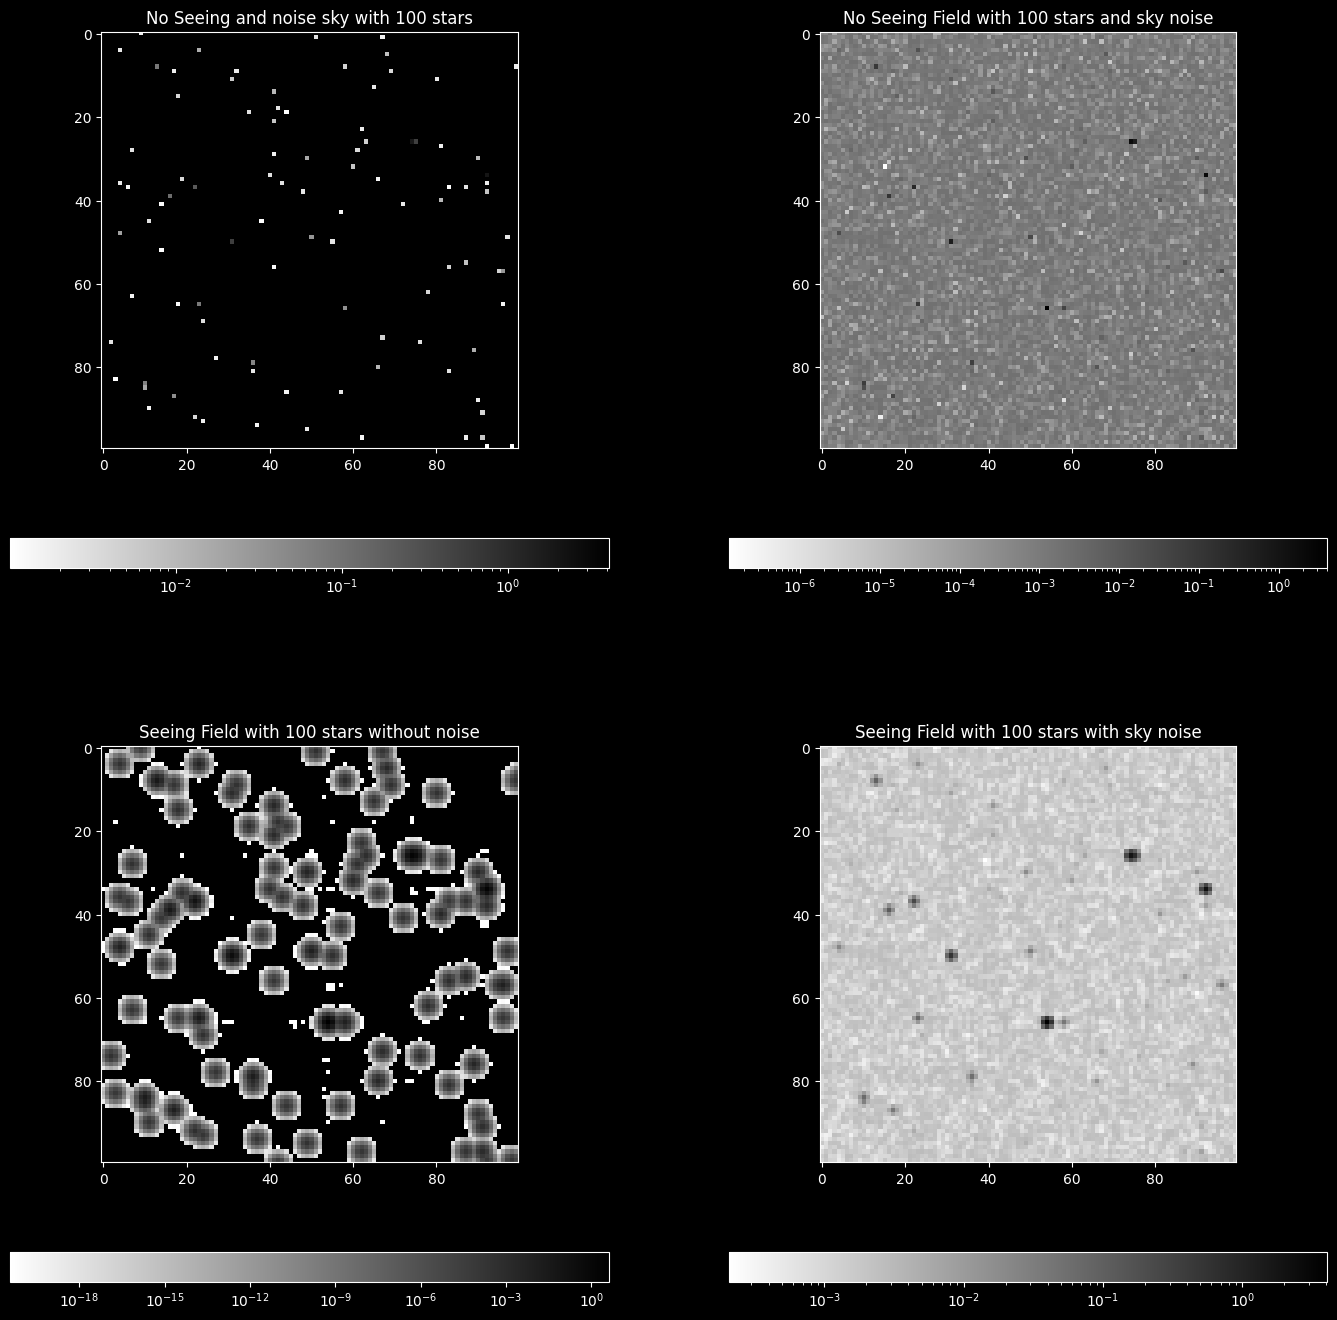

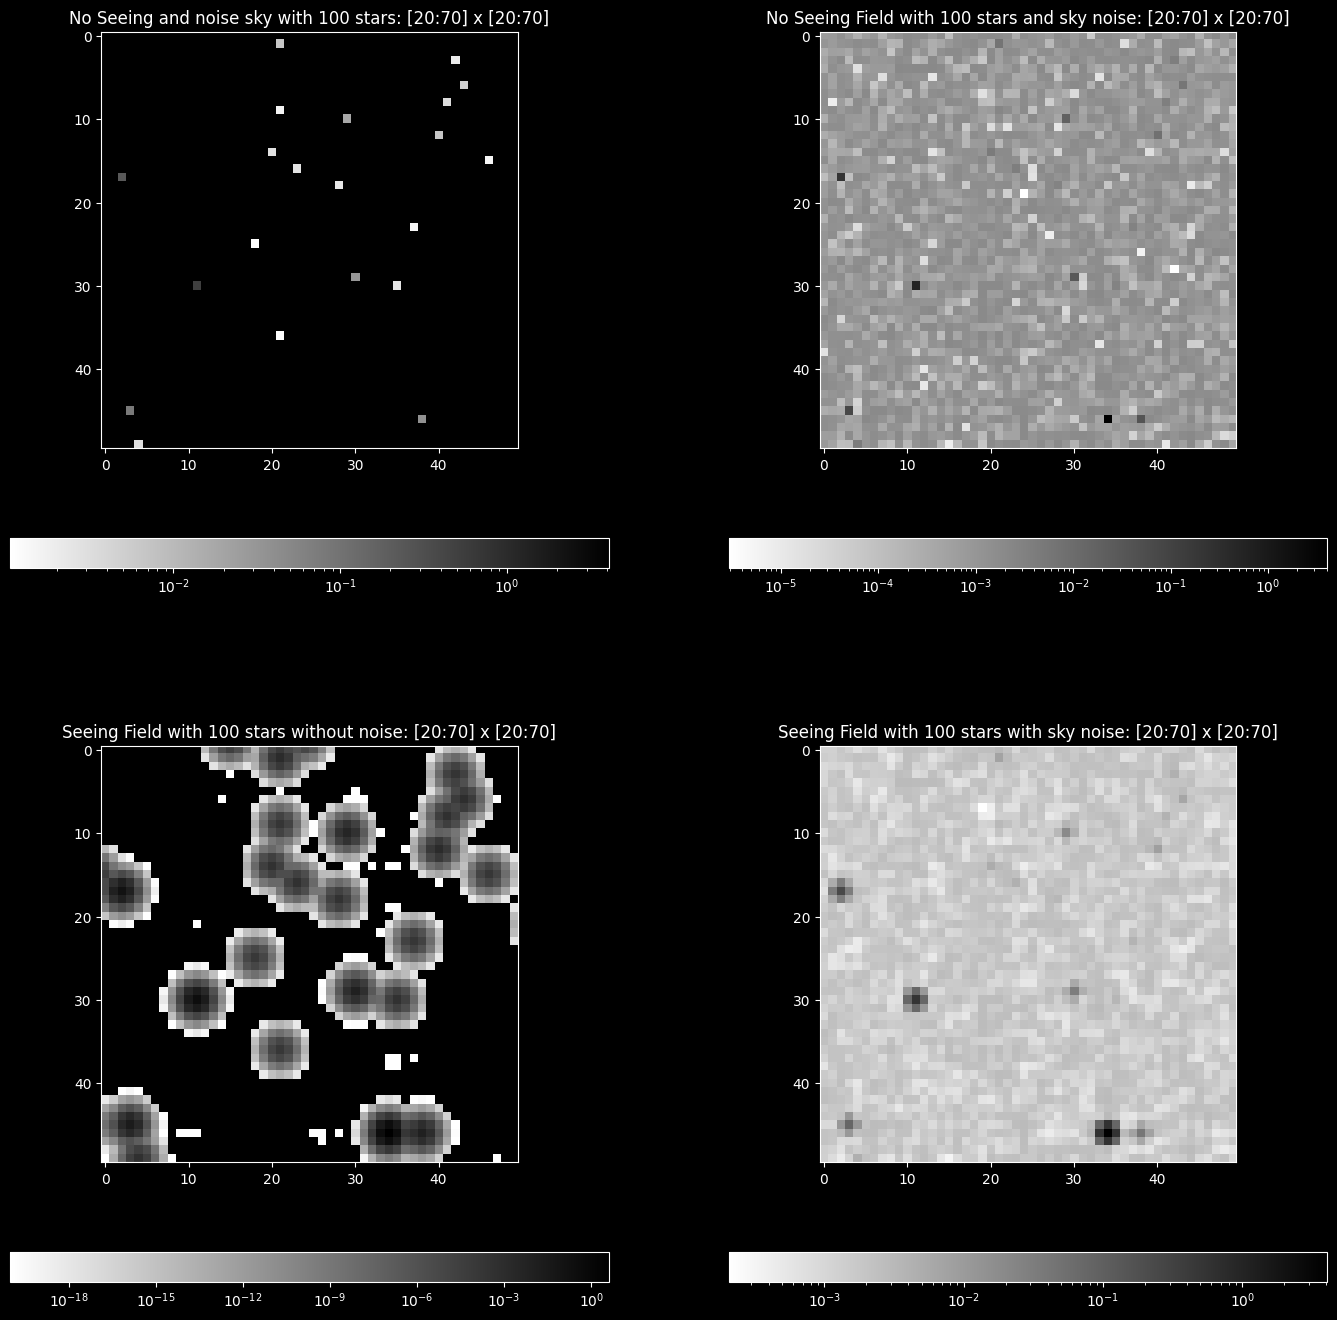

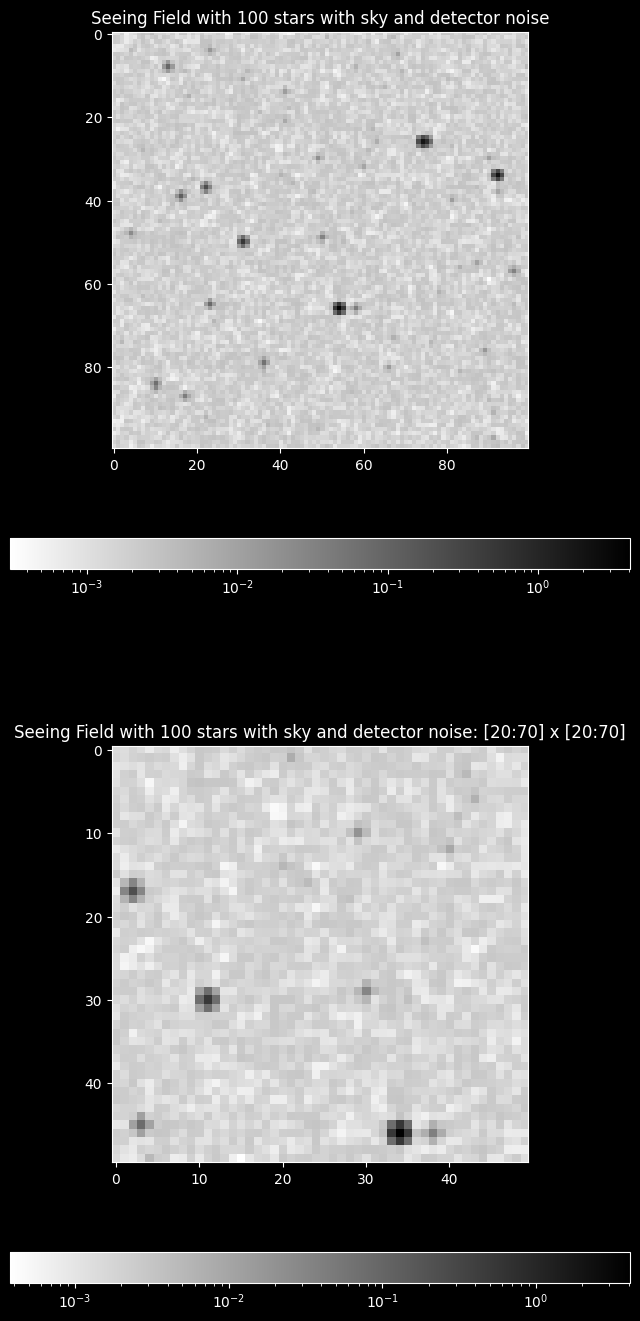

In [100]:


##* 
def noise(n: float, dim: int = N) -> np.ndarray:
    """Noise generator
    It generates a (dim,dim) matrix of noise, using
    an arbitrary maximum intensity n.

    :param n: max intensity of noise
    :type n: float
    :param dim: size of the field, defaults to N
    :type dim: int, optional

    :return: noise matrix
    :rtype: np.ndarray
    """
    # initializing the seed
    np.random.seed()
    # (`dim`,`dim`) matrix with random numbers 
    N0 = np.random.random((dim, dim))*n
    # checking the field
    return check_field(N0)

# background noise, set to 0.2 % of solar luminosity
bg_noise = 0.2/1e2

# detector noise
det_noise = 3e-4

# generation of the field and the stars
F, S = initialize()

# adding background noise
F_n = F + noise(bg_noise)


## Plot
fig1, ((img_field, img_field_noise),(img_field_seeing,img_field_snoise)) = plt.subplots(2,2,figsize=(17,17))
fig2, ((img_zoom, img_zoom_noise)  ,(img_zoom_seeing,img_zoom_snoise))   = plt.subplots(2,2,figsize=(17,17))
fig3, (img_field_tot, img_zoom_tot) = plt.subplots(2,1,figsize=(8,17))

#  0 : positive image
# -1 : negative image
v = -1


field_image(fig1, img_field,F,v)
img_field.title.set_text(f'No Seeing and noise sky with {M} stars')
field_image(fig2, img_zoom,F,v,[inf,sup])
img_zoom.title.set_text(f'No Seeing and noise sky with {M} stars: [{inf}:{sup}] x [{inf}:{sup}]')

field_image(fig1, img_field_noise,F_n,v)
img_field_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise')
field_image(fig2, img_zoom_noise,F_n,v,[inf,sup])
img_zoom_noise.title.set_text(f'No Seeing Field with {M} stars and sky noise: [{inf}:{sup}] x [{inf}:{sup}]')



# generating atmosferic seeing image without sky noise
F_s = atm_seeing(F)



field_image(fig1, img_field_seeing,F_s,v)
img_field_seeing.title.set_text(f'Seeing Field with {M} stars without noise')
field_image(fig2, img_zoom_seeing,F_s,v,[inf,sup])
img_zoom_seeing.title.set_text(f'Seeing Field with {M} stars without noise: [{inf}:{sup}] x [{inf}:{sup}]')



# generating atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n)



field_image(fig1, img_field_snoise,F_sn,v)
img_field_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise')
field_image(fig2, img_zoom_snoise,F_sn,v,[inf,sup])
img_zoom_snoise.title.set_text(f'Seeing Field with {M} stars with sky noise: [{inf}:{sup}] x [{inf}:{sup}]')


# adding detector noise
F_sn += noise(det_noise)


field_image(fig3, img_field_tot,F_sn,v)
img_field_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise')
field_image(fig3, img_zoom_tot,F_sn,v,[inf,sup])
img_zoom_tot.title.set_text(f'Seeing Field with {M} stars with sky and detector noise: [{inf}:{sup}] x [{inf}:{sup}]')

if sv == 1:
    fig1.savefig(os.path.join(picdir,'field_noise.png'))
    fig2.savefig(os.path.join(picdir,'zoom_noise.png'))
    fig3.savefig(os.path.join(picdir,'image.png'))

plt.show()


## II part: The detection

In this part the script focuses on searching and detecting objects in a field, generated as before. The aim is to recover the IMF, removing the seeing effect. 

### II.1 Dark elaboration

First I implemented a function to estimate the value of the detector noise through the computing of a set of darks.

max value =	0.0002943615614696584
mean value =	0.00014957226069370512


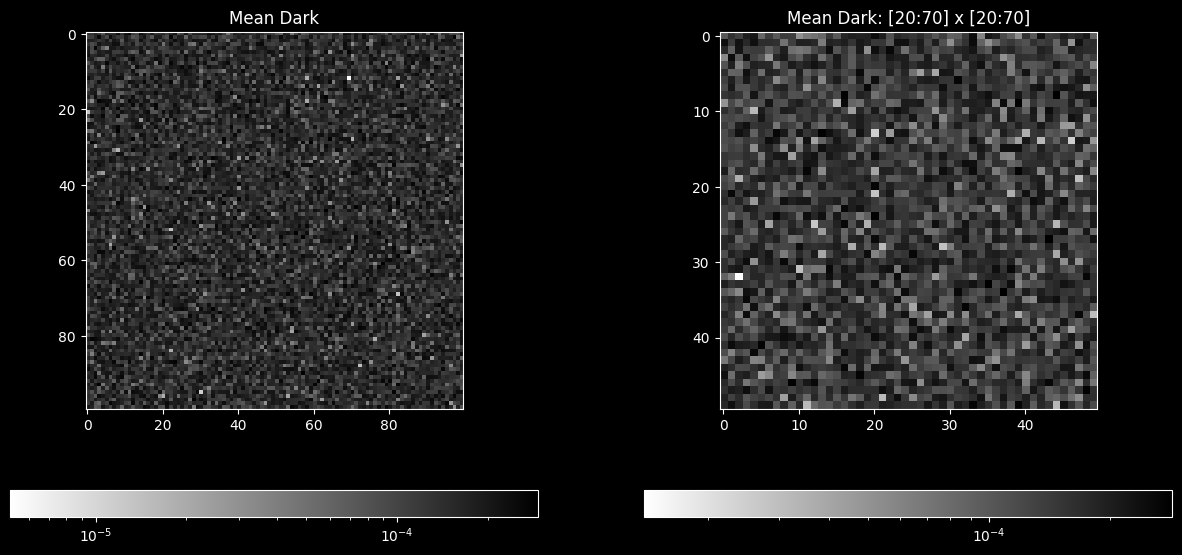

In [101]:

##*
def dark_elaboration(n_value: float = 3e-4, iteration: int = 3, dim: int = N) -> np.ndarray:
    """The function computes a number (`iteration`) of darks
    and averages them in order to get a mean estimation 
    of the detector noise

    :param n_value: detector noise, defaults to 3e-4
    :type n_value: float, optional
    :param iteration: number of darks to compute, defaults to 3
    :type iteration: int, optional

    :return: mean dark
    :rtype: np.ndarray
    """
    # generating the first dark
    dark = noise(n_value, dim=dim)
    # making the loop
    for i in range(iteration-1):
        dark += noise(n_value, dim=dim)
    # averaging
    dark /= iteration
    return dark

# doing the dark routine
dark = dark_elaboration()

print(f'max value =\t{dark[np.unravel_index(np.argmax(dark),dark.shape)]}')
print(f'mean value =\t{dark.sum()/(len(dark)**2)}')

## Plot
fig1, (dark_img, dark_zoom) = plt.subplots(1,2,figsize=(15,7))

#  0 : positive image
# -1 : negative image
v = -1

dark_img.set_title('Mean Dark')
field_image(fig1, dark_img,dark,v)
dark_zoom.set_title(f'Mean Dark: [{inf}:{sup}] x [{inf}:{sup}]')
field_image(fig1, dark_zoom,dark,v,[inf,sup])

plt.show()    

### II.2 Searching and extracting

![image](/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/tests/test_thr-precision.png)
![image](/home/bernardo/Scrivania/FISICA/ASTROFISICA/Astr_Oss/Progetti/proj_2/tests/test_thr-fake.png)

Consider the field with the seeing only. I want to recostruct the psf.

First, I locate the most luminous star of the field and isolate it, extracting the point around it. From this matrix I apply the algorith of Lucy to get the psf

**To do:**
1. **How to treat the presence of near objects**
2. **How to treat the limits of the field**
     - Maybe it is better rejecting those objects (?)

58


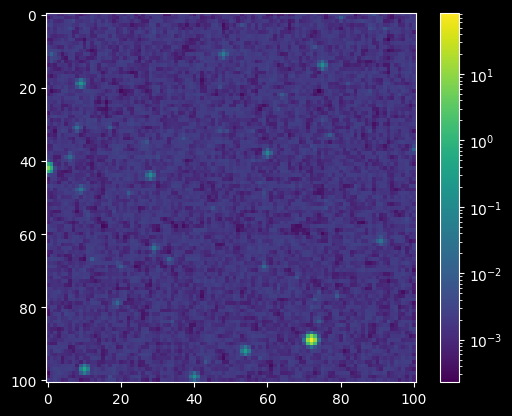

In [102]:
# from scipy.signal import argrelextrema

M = 100

# generation of the field and the stars
F, S = initialize(sdim=M)

# taking the 0.2% of the luminosity of a 1 solar mass star
# for 1 solar mass star L = M**beta = 1 in solar luminosity unit 
n = 0.2/1e2

objs = S.lum
objs = np.where(objs > n)[0]
objs = len(objs)
print(objs)

# add background noise
F_n = F + noise(n)

# detector noise
det_noise = 3e-4

# generate atmosferic seeing image without sky noise
F_s = atm_seeing(F, sigma=0.5)

# generate atmosferic seeing image with sky noise
F_sn = atm_seeing(F_n, sigma=0.5)

plt.imshow(F_sn, norm='log')
plt.colorbar()
plt.show()

84.03167395328254
84.03349343021043
dark =	0.0002959929198380752
max = 84.03349343021043
noise =	0.0016576867414714984
stn =	0.00 %
max = 6.4555623759641145
noise =	0.0016576867414714984
stn =	0.03 %
max = 0.39939345115519764
noise =	0.0016576867414714984
stn =	0.42 %
max = 0.2896624665963553
noise =	0.0016576867414714984
stn =	0.57 %
max = 0.1832162118230312
noise =	0.0016576867414714984
stn =	0.90 %
max = 0.16024070546259989
noise =	0.0016576867414714984
stn =	1.03 %
max = 0.12954033348372884
noise =	0.0016576867414714984
stn =	1.28 %
max = 0.1210249108108833
noise =	0.0016576867414714984
stn =	1.37 %
max = 0.08714998856239735
noise =	0.0016576867414714984
stn =	1.90 %
max = 0.058328189927399944
noise =	0.0016576867414714984
stn =	2.84 %
max = 0.03527488224685248
noise =	0.002
stn =	5.67 %
max = 0.03232332586988751
noise =	0.002
stn =	6.19 %
max = 0.029664184521976545
noise =	0.002
stn =	6.74 %
max = 0.028729569425900613
noise =	0.002
stn =	6.96 %
max = 0.02092208556326317
noise =	0.

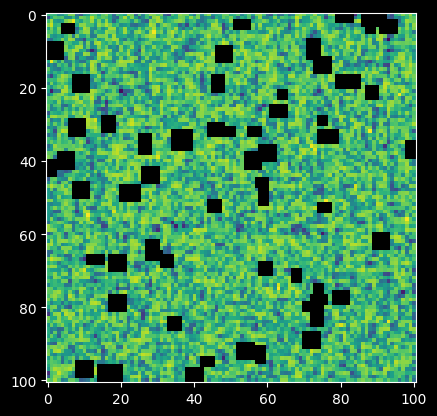


The star number is
Ext	True
59	100
Expected: 58
Precision: 101.72 %


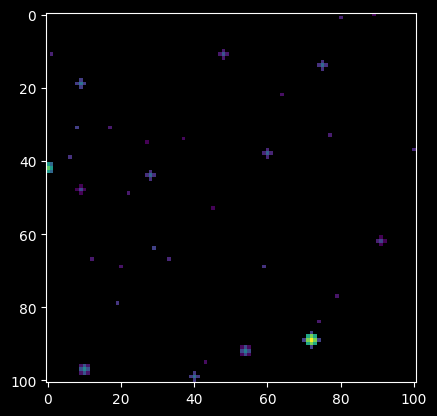

In [103]:
# add detector noise, set to 3e-4 (> than background one)
F_sn += noise(det_noise)

##* Detection
""" 
    For the recostruction of psf it's usefull only one star, 
    for exemple the most luminous one.
"""
#test_field = np.zeros((N,N))
test_field = F_sn.copy()
# find the maximum value coordinates
max_ind = np.unravel_index(np.argmax(test_field, axis=None), test_field.shape)

m_x, m_y = max_ind

print(max(S.lum))
print(test_field[max_ind])



def grad_check(field: np.ndarray, index: tuple[int,int], size: int = 3) -> tuple[np.ndarray,np.ndarray]:
    """Function explores the neighbourhood of a selected object and gives its size.
    It studies the gradient around the obj in the four cardinal directions and the diagonal ones.
    It takes in account also the presence of the edges of the field.
    If no other obj is found in a whichever direction, that one is stored and returned.

    :param field: the field matrix
    :type field: np.ndarray
    :param index: the obj coordinates
    :type index: tuple[int,int]
    :param size: the upper limit for the size of the obj, defaults to 3
    :type size: int, optional
    
    :return: a tuple with:
             * a_size : array with the size of the obj in each directions, like [x_up, x_down, y_up, y_down]
             * ind_neg : indeces in `a_size` for free directions
    :rtype: tuple[np.ndarray,np.ndarray]
    """    
    # field size
    dim = len(field)
    # object position
    x, y = index
    # treatment for edges; f stays for forward, b for backward
    xlim_f, ylim_f = min(size, dim-2-x), min(size, dim-2-y)
    xlim_b, ylim_b = min(size, x+1), min(size, y+1)
    # limits for the object
    xsize_f0, xsize_b0 = min(size, dim-1-x), min(size, x)
    ysize_f0, ysize_b0 = min(size, dim-1-y), min(size, y)
    # saving them in an array
    # the negative sign is used to take trace of free direction
    a_size0 = np.array([xsize_f0,xsize_b0,ysize_f0,ysize_b0], dtype=int) * -1
    # creating an array to store the size of the object in differt directions
    a_size = np.copy(a_size0)
    # moving in the four directions
    for i_f, i_b, j_f, j_b in zip(range(xlim_f), range(xlim_b), range(ylim_f), range(ylim_b)):
        # studying the sign of the gradient
        a_size[0] = i_f if (field[x+i_f+1, y]-field[x+i_f, y] >= 0 and a_size[0] == a_size0[0]) else a_size[0]
        a_size[1] = i_b if (field[x-i_b-1, y]-field[x-i_b, y] >= 0 and a_size[1] == a_size0[1]) else a_size[1]
        a_size[2] = j_f if (field[x, y+j_f+1]-field[x, y+j_f] >= 0 and a_size[2] == a_size0[2]) else a_size[2]
        a_size[3] = j_b if (field[x, y-j_b-1]-field[x, y-j_b] >= 0 and a_size[3] == a_size0[3]) else a_size[3]
        # diagonal
        a_size[0], a_size[2] = (i_f, j_f) if (field[x+i_f+1, y+j_f+1]-field[x+i_f, y+j_f] >= 0 and a_size[0] == a_size0[0] and a_size[2] == a_size0[2]) else  (a_size[0], a_size[2])
        a_size[0], a_size[3] = (i_f, j_b) if (field[x+i_f+1, y-j_b-1]-field[x+i_f, y-j_b] >= 0 and a_size[0] == a_size0[0] and a_size[3] == a_size0[3]) else  (a_size[0], a_size[3])
        a_size[1], a_size[2] = (i_b, j_f) if (field[x-i_b-1, y+j_f+1]-field[x-i_b, y+j_f] >= 0 and a_size[1] == a_size0[1] and a_size[2] == a_size0[2]) else  (a_size[1], a_size[2])
        a_size[1], a_size[3] = (i_b, j_b) if (field[x-i_b-1, y-j_b-1]-field[x-i_b, y-j_b] >= 0 and a_size[1] == a_size0[1] and a_size[3] == a_size0[3]) else  (a_size[1], a_size[3])
        # when for every direction there's an obj, the for cycle stops 
        if (True in (a_size == a_size0)) == False: break
    # looking for free direction
    condition = np.where(a_size < 0)[0]
    # if there is at least one
    if len(condition) != 0:
        # saving the indices
        ind_neg = condition
        # removing the sign
        a_size[ind_neg] *= -1
    # if there is none
    else:
        # storing the information
        ind_neg = np.array([-1])
    return a_size, ind_neg

"""
#  COSE DA AGGIUSTARE
#   X 1. capire come aggiustare la situazione quando 2 oggetti sono appiccicati
#   X 2. capire come tenere di conto del bordo
""" 
def approx_width(field: np.ndarray, index: tuple[int,int], thr: float = 1e-10, size: int = 3) -> tuple:
    """Extimation of the size of the object
    The function takes in input the most luminous point, calls the `grad_check()` function
    to investigate the presence of other objects and then to extimate the size of the
    target conditionated by the choosen threshold value.

    :param field: field matrix
    :type field: np.ndarray
    :param index: coordinates of the most luminous point
    :type index: tuple
    :param thr: threshold to get the size of the element, defaults to 1e-10
    :type thr: float
    :param size: the upper limit for the size of the obj, defaults to 3
    :type size: int, optional

    :return: a tuple with the size in each directions
    :rtype: tuple
    """
    # coordinates of the object
    x, y = index
    # saving the value in that position
    max_val = field[index]
    # getting the size of the object
    limits, ind_limits = grad_check(field,index,size)
    # condition for at least one free direction
    if ind_limits[0] != -1:
        # taking the maximum size in free direction group
        pos = max(limits[ind_limits])
        # storing the index for that direction
        ind_pos = np.where(limits == pos)[0][0]
    else:
        # taking the maximum size 
        ind_pos = int(np.argmax(limits))
        # storing its index
        pos = limits[ind_pos]
    # creating the parameter for the comparison
    ratio = 1
    # inizializing the index to explore the field
    i = 0
    # moving along x direction
    if ind_pos < 2:
        # direction for the exploration
        sign = (-2*ind_pos + 1)
        # take pixels until the threshold or the adge 
        while(ratio > thr and i < pos):
            i += 1
            # upload the parameter     
            ratio = field[x+sign*i,y]/max_val
    # moving along y direction
    else:
        # direction for the exploration
        sign = (-2*ind_pos + 5)
        # take pixels until the threshold 
        # take pixels until the threshold or the adge 
        while(ratio > thr and i < pos):
            i += 1     
            # upload the parameter     
            ratio = field[x,y+sign*i]/max_val
    # saving extimated width
    width = i
    # taking the min between width and size
    return tuple(min(width,i) for i in limits)

def object_isolation(obj: tuple[int,int], field: np.ndarray, coord: list[tuple], thr: float = 1e-10, size: int = 3) -> np.ndarray:
    """To isolate the most luminous star object.
    The function calls the `approx_width()` function 
    to extract from the field the object of interest.

    :param field: field matrix
    :type field: np.ndarray
    :param thr: threshold for `approx_width()` function, defaults to 1e-10
    :type thr: float, optional
    :param dim: size of the field, defaults to `N`
    :type dim: int, optional
    
    :return: the object matrix
    :rtype: np.ndarray
    """
    # calculating the size of the object
    wx_u, wx_d, wy_u, wy_d = approx_width(field, obj, thr=thr, size=size)
    # extracting the coordinates
    x, y = obj
    # printing infos
    # print(f'star ({x},{y}) val {field[obj]} -> {wx_u}, {wx_d}, {wy_u}, {wy_d}')
    # isolating the obj and coping in order to preserve the field matrix
    extraction = field[x - wx_d : x + wx_u +1, y - wy_d : y + wy_u +1].copy()
    # removing the object from the field
    field[x - wx_d : x + wx_u +1, y - wy_d : y + wy_u +1] = 0.0
    # removing the obj from the available points 
    for k in [(x+i, y+j) for i in range(-wx_d,wx_u+1) for j in range(-wy_d, wy_u+1)]:
        # control condition
        if k in coord: coord.remove(k)
    # #! DA RIMUOVERE PRIMA DI MANDARE !#
    # if M < 11:
    #     plt.imshow(extraction, norm='log')
    #     plt.colorbar()
    #     plt.show()
    #     plt.imshow(field, norm='log')   
    #     plt.colorbar()
    #     plt.show()
    # #!                               !#
    return extraction

##*
def evaluate_noise(field: np.ndarray, coord: list[tuple], point_num: int = 100, loop_num: int = 4) -> float:
    """To estimate the background noise value.
    The function draws points in the field and averages over them in order to get an estimation of the mean luminosity

    :param field: field matrix
    :type field: np.ndarray
    :param coord: list of possible position in the field
    :type coord: list[tuple]
    :param point_num: number of points to draw, defaults to 100
    :type point_num: int, optional
    :param loop_num: number of loops over which one want to average, defaults to 4
    :type loop_num: int, optional
    :return: the estimated noise value
    :rtype: float
    """
    # defining the variable for the estimated noise
    est_noise = 0
    # saving the size of coord
    dim = len(coord)
    # the number of points depends on the number of remained points in the field
    n_point = min(point_num, dim)
    # making `loop_num` drawing over which average
    for i in range(loop_num):
        # drawing positions in the coordinates list
        ind = np.random.choice(dim, size=n_point, replace=False)
        # making an array for the drawn elements
        element = np.array([field[coord[i]] for i in ind])
        # evaluating the mean
        est_noise += sum(element)/len(element)
    # averaging
    est_noise /= loop_num
    return est_noise

##*
def counting_stars(field: np.ndarray, dark_noise: float, thr: float = 1e-3, size: int = 3, coord: list[tuple] = [], point_num: int = 100, loop_num: int = 4) -> list[np.ndarray]:
    """Extracting stars from field
    The function calls the `object_isolation()` function iteratively until
    the signal-to-noise ratio (`s_t_n`) is less than 2

    :param field: field matrix
    :type field: np.ndarray
    :param dark_max: threshold for consider a signal
    :type dark_max: float
    :param thr: threshold for the size of an obj, defaults to 1e-3
    :type thr: float, optional
    :param size: max size of an obj, defaults to 3
    :type size: int, optional

    :return: the list of extracted object. Its len() is the number of found obj
    :rtype: list[np.ndarray]
    """
    # coping the field to preserve it
    tmp_field = field.copy()
    # saving size of the field
    dim = len(tmp_field)
    # creating an empty list to store the extracted objects
    a_extraction = []
    # evaluating the maximum in the field
    max_pos = np.unravel_index(np.argmax(tmp_field, axis=None), tmp_field.shape)
    max_val = tmp_field[max_pos]
    # printing it
    print(f'max = {max_val}')
    # generating list with all possible position, if it was not 
    if len(coord) == 0:  
        coord = [(i,j) for i in range(dim) for j in range(dim)]
    # Before the search of objects, let's set an initial value for the noise, 
    #   that will set the condition to start the estimation of the signal-to-noise ratio
    # first noise value
    n0 = evaluate_noise(tmp_field, coord, point_num=100, loop_num=loop_num)
    # averaging with the noise from dark
    n0 = (n0 + dark_noise) / 2
    # taking the minimum between n and the 10% of maximum luminosity
    n0 = min(n0, max_val/10)
    print(f'noise =\t{n0}')
    #! for me to control
    i = 0
    # evaluating the signal-to-noise ratio
    s_t_n = max_val / n0
    print(f'stn =\t{1/s_t_n*100:.2f} %')
    # starting the loop 
    while s_t_n > 2 and i < M:
        # appending the new extracted object to the list
        a_extraction += [object_isolation(max_pos, tmp_field, coord, thr, size)]
        # evalueting the new maximum in the field
        max_pos = np.unravel_index(np.argmax(tmp_field, axis=None), tmp_field.shape)
        max_val = tmp_field[max_pos]
        print(f'max = {max_val}')
        # condition to start the noise evaluation
        if s_t_n <= 50:
            n0 = evaluate_noise(field,coord,point_num,loop_num)
            # taking the max between n and noise from dark
            n0 = max(n, dark_noise)
        print(f'noise =\t{n0}')
        s_t_n = max_val/n0
        print(f'stn =\t{1/s_t_n*100:.2f} %')
        i += 1
        if i == M: print('!WARNING!: ITERATION EXCEDED!')
    plt.imshow(tmp_field, norm='log')
    plt.show()
    return a_extraction

# mean dark
dark = dark_elaboration(det_noise)
# for the noise estimated from dark take the maximum
d = dark[np.unravel_index(np.argmax(dark), dark.shape)]
print(f'dark =\t{d}')

# number of points
p_num = 200 
# thr to define an obj
thr = 1e-1
a_extraction = counting_stars(test_field, d, thr=thr, size=3, point_num=p_num)
print(f'\nThe star number is\nExt\tTrue\n{len(a_extraction)}\t{M}')
print(f'Expected: {objs}')
print(f'Precision: {len(a_extraction)/objs*100:.2f} %')

# extraction = a_extraction[0]

selected = a_extraction[-1]
thr_tmp = selected[np.unravel_index(np.argmax(selected), selected.shape)]



plt.imshow(np.where(F_s>thr_tmp, F_s, 0.0), norm='log')
# plt.imshow(F_s, norm='log')
plt.show()


0.00015026084224375102


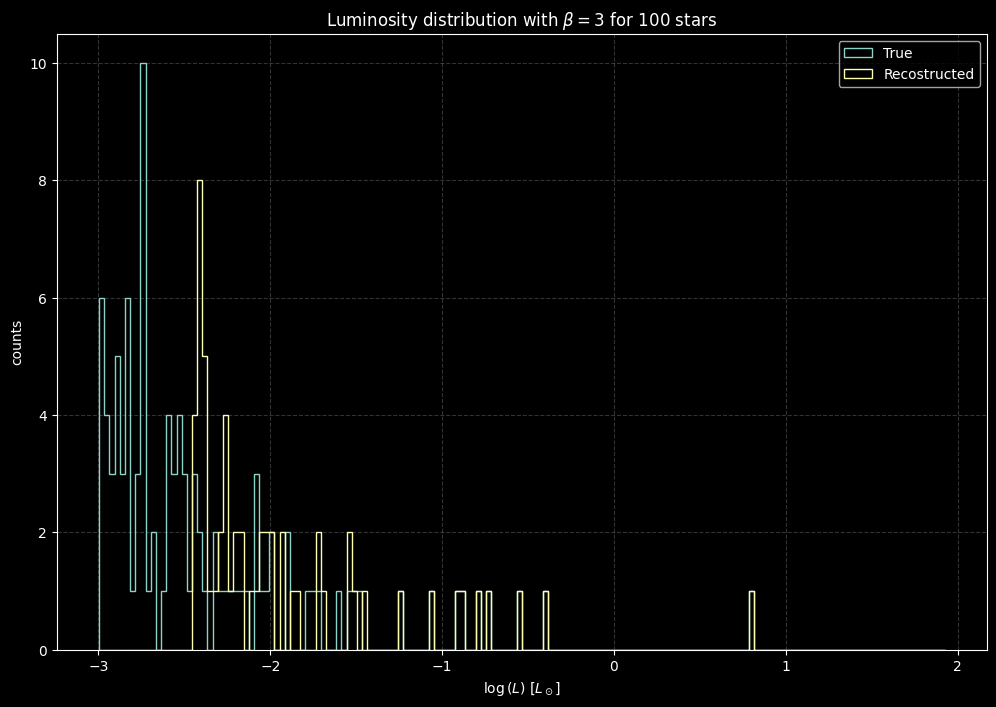

In [104]:
L_r = np.array([])
for element in a_extraction:
    L_r = np.append(L_r, element[np.unravel_index(np.argmax(element), element.shape)])

dark = dark_elaboration(det_noise)
L_r -= dark.sum()/(len(dark)**2)
print(dark.sum()/(len(dark)**2))

plt.figure(figsize=(12,8))
plt.title(f'Luminosity distribution with $\\beta = {beta}$ for {M} stars')
bins = np.arange(min(np.log10(S.lum).min(),np.log10(L_r).min()), max(np.log10(S.lum).max(), np.log10(L_r).max()), 0.03)
# print(bins)
plt.hist(np.log10(S.lum),bins=bins,histtype='step', label='True')
plt.hist(np.log10(L_r-d), bins=bins, histtype='step', label='Recostructed')
#plt.xticks(np.arange(-3.1,1.16,0.5))
plt.xlabel('$\log{(L)}$ [$L_\odot$]')
plt.ylabel('counts')
plt.legend()
plt.grid(linestyle='--', alpha=0.2)
plt.show()

### Lucy recostrucion



In [105]:
n = len(extraction)
H = extraction
See = extraction[1:-1,1:-1]
W = np.array([])
print(See)
# I = J = K = L = n
# a = max(1, m-K+1)     b = min(m, I)
# c = max(1, l-L+1)     d = min(l, J)
# e = i+K-1             f = j+L-1
#
# W_ij,0 = sum_{m=i}^e sum_{l=j}^f ( H_ml * S_m-i+1,l-j+1 ) / ( sum_{p=a}^b sum_{q=c}^d S_m-p+1,l-q+1 ) 
n -= 2
summing = lambda i,j : sum( sum( H[m][l] * See[m-i][l-j] / sum( sum( See[m-p][l-q] for q in range(max(0,l-n+1), min(l+1,n-1)) ) for p in range(max(0, m-n+1), min(m+1,n-1)) ) for l in range(j, j+n-1) ) for m in range(i, i+n-1) )
W0 = np.array([[ summing(i,j)  for j in range(n)] for i in range(n)])
# print([[[ [ sum( sum( See[m-p][l-q] for q in range(max(0,l-n+1), min(l+1,n-1)) ) for p in range(max(0, m-n+1), min(m+1,n-1)) ) for l in range(j, j+n-1) ] for m in range(i, i+n-1) ] for j in range(n)] for i in range(n)])

iter = 20

def W(r):
    if r==1:
        return np.array([[ summing(i,j)  for j in range(n)] for i in range(n)])
    else:
        Wr = W(r-1)
        return np.array([[ Wr[i,j] * sum( sum( H[m][l] * See[m-i][l-j] / sum( sum( Wr[p][q] * See[m-p][l-q] for q in range(max(0,l-n+1), min(l+1,n-1)) ) for p in range(max(0, m-n+1), min(m+1,n-1)) ) for l in range(j, j+n-1) ) for m in range(i, i+n-1) )  for j in range(n)] for i in range(n)])

plt.figure(1,figsize=[12,12])
for i in range(n):
    for j in range(n):
        plt.subplot(3,3,i*n+j+1)
        plt.plot([W(r+1)[i,j] for r in range(iter)], '.-', label=f'({i},{j})')
        plt.legend()
plt.figure(2)
plt.imshow(W(iter),norm='log')
plt.colorbar()

print(W(iter))

plt.show()
# np.append(W,)

NameError: name 'extraction' is not defined